<a href="https://colab.research.google.com/github/abivilion/Image-Captioning/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Chaittanyak/Open-CV/blob/main/subject_121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`%tensorflow_version 2.x` is to check correct version for TensorFlow.
 

In [ ]:
#Accessing your drive from colab
#sign in and enter token for auth.
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 2.x

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'


**Importing Libraries required**

In [ ]:
import os
import string
import glob
import pickle
from time import time
import numpy as np
from PIL import Image
from tqdm import tqdm

from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
import tensorflow.keras.preprocessing.image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization)           
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

Using function to format time strings

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Downloading datasets, Text and resources as required

* [GloVe.6B](https://nlp.stanford.edu/projects/glove/) 
* [Flicker8k_Text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)
* [Flicker8k_Dataset](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip) 

In [ ]:
root_captioning = "/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured"

### Cleaning dataset.

In [ ]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()
with open( os.path.join(root_captioning,'/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flickr8k_text','/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flickr8k_text/Flickr8k.token.txt'), 'r') as fp:                       
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


In [7]:
glove_dir = os.path.join(root_captioning,'/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400001it [00:25, 15836.10it/s]

Found 400001 word vectors.


**A brief statistics of data**

In [8]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


In [9]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset', '*.jpg'))
len(img)

8091

Redefining all image names

In [10]:
train_images_path = os.path.join(root_captioning,\
            '/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            '/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 
print(len(train_images))
print(len(test_images))

6000
1000


In [11]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'
len(train_descriptions)

6000

In [12]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 2s 0us/step


The whole summary of image neural network to be transferred

In [13]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Training DataSet

*   Resize all images to a standard size 
*   Conver a PIL image to np.array
*   Expanding 2D array
*   Pre-processing
*   Extracting features











In [14]:
def encodeImage(img):
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encode_model.predict(x) 
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [15]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [16]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

We're separating captions here . Whereas training takes place for images as well as captions

In [17]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Here we are removing words that occur less than ten times

In [18]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next, we build two lookup tables for this vocabulary. The 

*   idxtoword converts index numbers to actual words indexing values
*   The wordtoidx was the opposite
.

In [19]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Before, we have added a start and stop token to all sentence

In [20]:
max_length +=2
print(max_length)

34


In [21]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Building NN

 We are going to copy this matrix to the weight matrix of the neural network.

In [22]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).Dimensions of matrix

In [23]:
embedding_matrix.shape

(1652, 200)

In [24]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [25]:
embedding_dim

200

In [26]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [27]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [28]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [29]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    



# **Captioning**

In [30]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# **Text to Speech** 

Using Google TTS Facility for converting Text into Speech output.

*This is system directly going to used in Service Area.* 

**Dependencies**: 
This feature is depended on 2 things : 
1. User Internet Connection Service
2. Google's API Service


**Fault Tolerance**: Cavi's System internal Fault Tolerance is 99.99% SLA on-marked . Cavi Effigies is not responsible for fault tolerance on above dependencies.

**Installing gtts module**

In [31]:
!pip install gtts
!pip install playsound 
!pip install pygobject # Sub-System

  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=8bd5068a9259e8b8c1aa9e9202851fcc44c18175e27967f821619c9ceee59c25
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


**Main Code Function**

In [32]:
from gtts import gTTS
import playsound
import librosa
import IPython.display as ipd


def speak(txt):
    tts = gTTS(text=txt,lang= "en-US")
    filename = "utter.mp3" # created file
    tts.save(filename)
    x,we=librosa.load('utter.mp3')
    ipd.Audio(x,rate=we) 

    # os.remove("utter.mp3") # decomposing created voice file


    

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


#**TESTING AREA**

### Testing Flicker8k data

This model performs relatively well on images that are similar to the training set.

/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset/2484190118_e89363c465.jpg


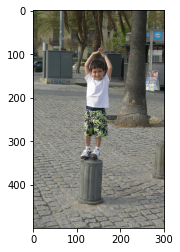


Caption: girl in pink dress is walking along the sidewalk
_____________________________________
/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg


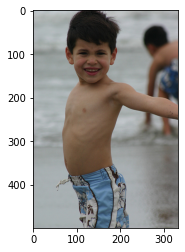


Caption: young boy in swim trunks is running through shallow water
_____________________________________
/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset/3729525173_7f984ed776.jpg


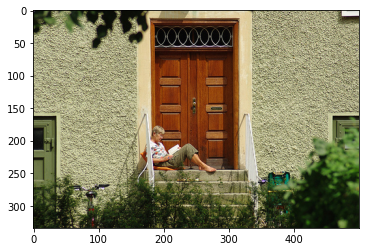


Caption: man in black shirt is standing on the sidewalk with his arms out
_____________________________________
/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset/3396157719_6807d52a81.jpg


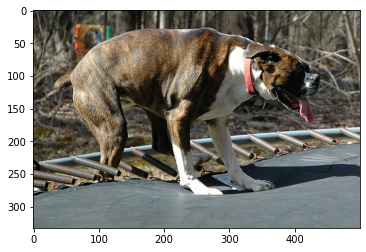


Caption: brown and white dog is running through the grass
_____________________________________
/content/drive/Othercomputers/My Laptop/Achievecert/Captioning the Captured/Flicker8k_Dataset/3107513635_fe8a21f148.jpg


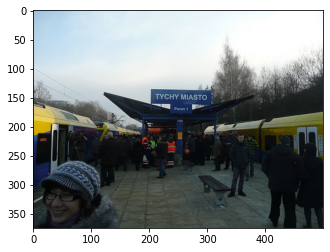


Caption: man in black and white striped shirt is standing in front of crowd
_____________________________________


In [33]:
for z in range(5):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()

  print("")
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [34]:
encoding_test[pic].shape

(2048,)

### Testing with non-related dataset Images

These are entirely separate from the data of Flicker8K dataset, and so, this neural network model does exhibit lower accuracy

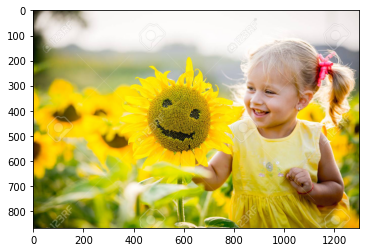

(1, 2048)
Caption: little girl in pink dress is standing in front of flower
_____________________________________


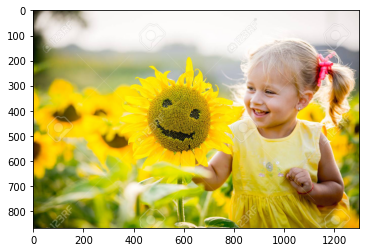

(1, 2048)
Caption: little girl in pink dress is standing in front of flower
_____________________________________


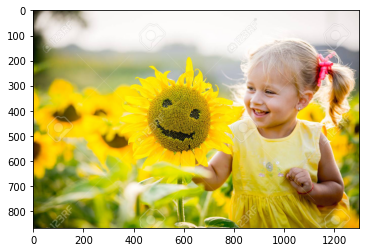

(1, 2048)
Caption: little girl in pink dress is standing in front of flower
_____________________________________


In [40]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

ROOT = "https://previews.123rf.com/images/sushytska/sushytska1610/sushytska161000338/66527660-happy-little-girl-on-the-field-of-sunflowers-in-summer-beautiful-little-girl-in-sunflowers.jpg"
urls = [
  ROOT+"annie_dog.jpg?raw=true",
  ROOT+"landscape.jpg?raw=true",
  ROOT+"hickory_coat.jpg?raw=true"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")

#**Service Area**

Hi! there, I'm Cavi
 I'm your voice assitant. Attach the image link below: 
https://previews.123rf.com/images/sushytska/sushytska1610/sushytska161000338/66527660-happy-little-girl-on-the-field-of-sunflowers-in-summer-beautiful-little-girl-in-sunflowers.jpg


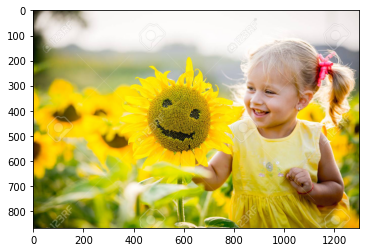

(1, 2048)
Caption: little girl in pink dress is standing in front of flower


Do you want Speech output?
y/n? ->y
Available Languages:  Go To

 https://cloud.google.com/text-to-speech/docs/voices


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


_____________________________________


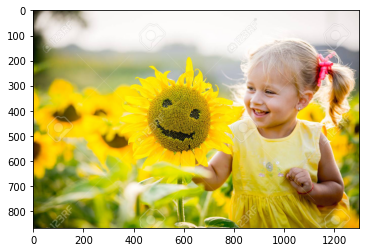

(1, 2048)
Caption: little girl in pink dress is standing in front of flower


Do you want Speech output?
y/n? ->y
Available Languages:  Go To

 https://cloud.google.com/text-to-speech/docs/voices


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


_____________________________________


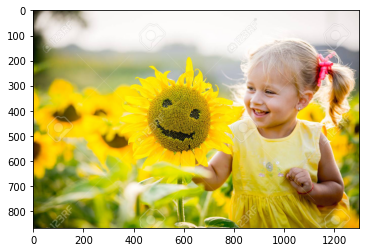

(1, 2048)
Caption: little girl in pink dress is standing in front of flower


Do you want Speech output?


KeyboardInterrupt: ignored

In [ ]:
print("Hi! there, I'm Cavi")
print(" I'm your voice assitant. Attach the image link below: ")


ROOT = input()
urls = [
  ROOT+"annie_dog.jpg?raw=true",
  ROOT+"landscape.jpg?raw=true",
  ROOT+"hickory_coat.jpg?raw=true"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))

  print(img.shape)
  caption = generateCaption(img)

# Text only
  print("Caption:",caption)
  print()
  print()
  print("Do you want Speech output?")
  ans=input("y/n? ->")

  if(ans=="y"):
     print("Available Languages:  Go To")
     print("\n https://cloud.google.com/text-to-speech/docs/voices")
    #  choose = input("Enter Language Code : ")

     speak(caption)
    
  print("_____________________________________")

In [ ]:
     print( '<a href="where/you/want/the/link/to/go">text of the link</a>')


<a href="where/you/want/the/link/to/go">text of the link</a>
